### FilterNet
A neural network for filtering out gaussian noise from an image introduced by aggressive accelerations on the vehicle carrying the camera.

In [29]:
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from skimage import io, transform
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, utils
from typing import List, Dict, Tuple
from tqdm import tqdm

### Dataset Class and Dataloader

In [ ]:
# Set device to cuda
device = torch.device('cuda:0')

# Create dataset class
class VideoDataset(Dataset):
    def __init__(self, path_to_data, augmented=False, num_vids=7, seq_length=5, img_size=256):
        """
        Go through each video folder and build a map from
        index i in range [0, N], where N is the total number
        of frames in all the videos, to a tuple (j, k), where
        j is the video number and k the frame index in that
        video. For reference, the videos are stored in the
        dataset as:

        data:
        - test1:
          - inputs:
            - bd_poses.csv
            - bd_twists.csv
            - frame0000.png
            - frame0001.png
            - ...
          - targets:
            - frame0000.png
            - frame0001.png
            - ...
        - test2:
            - ...
        - ...
        """
        self.img_size = img_size
        self.seq_length = seq_length
        self.augmented = augmented
        self.num_vids = num_vids
        self.path_to_data = path_to_data
        self.idx_map: List[Tuple[int, int]] = []
        self.poses: Dict[int, np.ndarray] = {}
        self.twists: Dict[int, np.ndarray] = {}
        for i in tqdm(range(1, self.num_vids + 1)):
            # Define path to pose
            pose_path = os.path.join(path_to_data, f'test{i}/inputs/bd_poses.csv')
            twist_path = os.path.join(path_to_data, f'test{i}/inputs/bd_twists.csv')

            # Check that files were opened properly
            if not os.path.isfile(pose_path):
                raise FileNotFoundError(f"Missing pose file: {pose_path}")
            if not os.path.isfile(twist_path):
                raise FileNotFoundError(f"Missing twist file: {twist_path}")

            # Get poses
            self.poses[i] = pd.read_csv(pose_path).to_numpy()
            self.twists[i] = pd.read_csv(twist_path).to_numpy()

            # Get number of sequences in this video: num_frames - (seq_length - 1)
            num_sequences = (self.poses[i].shape[0] - 1) - (self.seq_length - 1)

            # Update index map
            video_num = [i] * num_sequences
            frame_idx = list(range(0, num_sequences))
            self.idx_map.extend(list(zip(video_num, frame_idx)))

        self.total_num_sequences = len(self.idx_map)

    def __len__(self):
        """
        Return length of dataset as computed in __init__() function.
        """
        return self.total_num_sequences

    def __getitem__(self, idx):
        """
        Use map built in __init__() to retrieve the image,
        pose, and twist directly from the dataset.
        This avoids loading the entire dataset which
        overwhelms RAM.
        """
        assert idx < self.total_num_sequences
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq_start = True
        for i in range(self.seq_length):
            # Define path to data
            test_idx, frame_idx = self.idx_map[idx]
            frame_idx += i
            padded_frame_idx = self.to_zero_pad_idx(frame_idx)
            input_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/inputs/frame{padded_frame_idx}.png')
            output_img_path = os.path.join(self.path_to_data,
                                    f'test{test_idx}/targets/frame{padded_frame_idx}.png')

            # Debug:
            # print(f'\ntest idx, frame idx: {test_idx, frame_idx}')

            # Load and process data
            input_frame = io.imread(input_img_path)
            output_frame = io.imread(output_img_path)
            input_frame = torch.from_numpy(self.to_grayscale(input_frame)).float()
            output_frame = torch.from_numpy(self.to_grayscale(output_frame)).float()
            pose = self.poses[test_idx][frame_idx]
            pose = torch.from_numpy(self.pose_vector_from_matrix(pose).reshape(-1, 1)).float()
            twist = torch.from_numpy(self.twists[test_idx][frame_idx].reshape(-1, 1)).float()
            state = torch.cat((pose, twist), dim=0).view(-1)

            # Resize frames
            h, w = self.img_size, self.img_size
            resize_frame = transforms.Resize((h, w))
            output_frame = resize_frame(output_frame.unsqueeze(0))
            input_frame = resize_frame(input_frame.unsqueeze(0))

            if not self.augmented:
                # Initialize sequence
                if seq_start:
                    in_frame_seq = torch.zeros_like(input_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    out_frame_seq = torch.zeros_like(output_frame).view(1, 1, h, w).repeat((self.seq_length, 1, 1, 1))
                    state_seq = torch.zeros_like(state).unsqueeze(0).repeat((self.seq_length, 1))
                    seq_start = False

                # Update sequence
                in_frame_seq[i] = input_frame.view(1, h, w)
                out_frame_seq[i] = output_frame.view(1, h, w)
                state_seq[i] = state

            # If we want a broadcasted frame, pose, twist tensor of shape (B, T, 1, H, W, 14)
            else:
                expanded_frame = input_frame.view(1, h, w, 1)
                expanded_state = state.view(1, 1, 1, -1).repeat(1, h, w, 1)
                augmented_frame = torch.cat((expanded_frame, expanded_state), dim=-1)

                # Initialize augmented sequence
                if seq_start:
                    aug_seq_in = torch.zeros_like(augmented_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1, 1))
                    aug_seq_out = torch.zeros_like(output_frame).unsqueeze(0).repeat((self.seq_length, 1, 1, 1))
                    seq_start = False

                # Update augmented sequence
                aug_seq_in[i] = augmented_frame
                aug_seq_out[i] = output_frame

        return {'input': (in_frame_seq, state_seq), 'target': out_frame_seq} if not self.augmented else {'input': aug_seq_in, 'target': aug_seq_out}

    def to_zero_pad_idx(self, idx):
        """
        Convert frame index from regular index to zero-padded index.
        e.g. 1 -> 00001, 12 -> 00012
        """
        return f'{idx:05d}'

    def pose_vector_from_matrix(self, pose):
        """
        Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
        """
        pose = pose.reshape(4, 4)
        position = pose[:3, 3].reshape(3, 1)
        orientation = pose[:3, :3]

        quat = R.from_matrix(orientation).as_quat().reshape(-1, 1)
        norm_quat = quat / np.linalg.norm(quat)

        return np.vstack((position, norm_quat)).reshape(-1)

    def to_grayscale(self, image):
        """
        Convert PNG image to grayscale mask
        """
        #TODO: Try float16 type
        return (image[..., 0] > 127).astype(np.float32)


In [ ]:

import torch.nn.functional as F

class PoseEncoder(nn.Module):
    """Encodes pose/twist information to feature embeddings"""
    def __init__(self, pose_dim=13, hidden_dim=64, output_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(pose_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, pose):
        # pose: (B, T, 13)
        B, T, _ = pose.shape
        pose_flat = pose.view(B * T, -1)
        features = self.encoder(pose_flat)  # (B*T, output_dim)
        return features.view(B, T, -1)  # (B, T, output_dim)

class SpatialAttention(nn.Module):
    """Spatial attention module to focus on moving object regions"""
    def __init__(self, in_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 8, 1)
        self.conv2 = nn.Conv2d(in_channels // 8, 1, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: (B, C, H, W)
        attention = self.conv1(x)
        attention = F.relu(attention)
        attention = self.conv2(attention)
        attention = self.sigmoid(attention)
        return x * attention

class TemporalBlock(nn.Module):
    """3D convolutional block for temporal modeling"""
    def __init__(self, in_channels, out_channels, kernel_size=(3, 3, 3), stride=1, padding=1):
        super().__init__()
        self.conv3d = nn.Conv3d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()
        self.spatial_attention = SpatialAttention(out_channels)

    def forward(self, x):
        # x: (B, C, T, H, W)
        x = self.conv3d(x)
        x = self.bn(x)
        x = self.relu(x)

        # Apply spatial attention frame by frame
        B, C, T, H, W = x.shape
        x_reshaped = x.permute(0, 2, 1, 3, 4).contiguous().view(B * T, C, H, W)
        x_attended = self.spatial_attention(x_reshaped)
        x = x_attended.view(B, T, C, H, W).permute(0, 2, 1, 3, 4)

        return x

class PoseGuidedFusion(nn.Module):
    """Fuses pose information with visual features"""
    def __init__(self, visual_channels, pose_features, output_channels):
        super().__init__()
        self.pose_proj = nn.Linear(pose_features, visual_channels)
        self.fusion_conv = nn.Conv2d(visual_channels * 2, output_channels, 1)

    def forward(self, visual_features, pose_features):
        # visual_features: (B, C, T, H, W)
        # pose_features: (B, T, pose_dim)
        B, C, T, H, W = visual_features.shape

        # Project pose features to match visual channel dimension
        pose_proj = self.pose_proj(pose_features)  # (B, T, C)
        pose_proj = pose_proj.unsqueeze(-1).unsqueeze(-1)  # (B, T, C, 1, 1)
        pose_proj = pose_proj.expand(-1, -1, -1, H, W)  # (B, T, C, H, W)

        # Reshape for frame-wise processing
        visual_flat = visual_features.permute(0, 2, 1, 3, 4).contiguous().view(B * T, C, H, W)
        pose_flat = pose_proj.contiguous().view(B * T, C, H, W)

        # Concatenate and fuse
        fused = torch.cat([visual_flat, pose_flat], dim=1)  # (B*T, 2*C, H, W)
        output = self.fusion_conv(fused)  # (B*T, output_channels, H, W)

        # Reshape back
        output = output.view(B, T, -1, H, W).permute(0, 2, 1, 3, 4)
        return output

class FilterNet(nn.Module):
    """
    Neural network for denoising video masks of moving objects
    Compatible with your existing training setup

    Args:
        input_shape: (H, W) - spatial dimensions of input frames
        pose_dim: dimension of pose/twist information (default: 13)
        hidden_channels: number of hidden channels in conv layers
    """
    def __init__(self, input_shape=(256, 256), pose_dim=13, hidden_channels=64):
        super().__init__()
        self.input_shape = input_shape
        self.pose_dim = pose_dim
        self.hidden_channels = hidden_channels

        # Pose encoder
        self.pose_encoder = PoseEncoder(pose_dim, 64, 128)

        # Encoder (downsampling path)
        self.encoder1 = TemporalBlock(1, hidden_channels, kernel_size=(3, 3, 3))
        self.encoder2 = TemporalBlock(hidden_channels, hidden_channels * 2, kernel_size=(3, 3, 3))
        self.encoder3 = TemporalBlock(hidden_channels * 2, hidden_channels * 4, kernel_size=(3, 3, 3))

        # Pose-guided fusion
        self.pose_fusion = PoseGuidedFusion(hidden_channels * 4, 128, hidden_channels * 4)

        # Bottleneck
        self.bottleneck = TemporalBlock(hidden_channels * 4, hidden_channels * 8, kernel_size=(3, 3, 3))

        # Decoder (upsampling path)
        self.decoder3 = TemporalBlock(hidden_channels * 8 + hidden_channels * 4, hidden_channels * 4, kernel_size=(3, 3, 3))
        self.decoder2 = TemporalBlock(hidden_channels * 4 + hidden_channels * 2, hidden_channels * 2, kernel_size=(3, 3, 3))
        self.decoder1 = TemporalBlock(hidden_channels * 2 + hidden_channels, hidden_channels, kernel_size=(3, 3, 3))

        # Output layer
        self.output_conv = nn.Conv3d(hidden_channels, 1, kernel_size=(1, 1, 1))
        self.sigmoid = nn.Sigmoid()

        # Pooling layers
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))

    def forward(self, video_masks, pose_info):
        """
        Forward pass

        Args:
            video_masks: (B, T, 1, H, W) - input video masks
            pose_info: (B, T, 13) - pose/twist information

        Returns:
            denoised_masks: (B, T, 1, H, W) - denoised output masks
        """
        B, T, C, H, W = video_masks.shape

        # Rearrange to (B, C, T, H, W) for 3D convolutions
        x = video_masks.permute(0, 2, 1, 3, 4)

        # Encode pose information
        pose_features = self.pose_encoder(pose_info)  # (B, T, 128)

        # Encoder path with skip connections
        enc1 = self.encoder1(x)  # (B, 64, T, H, W)
        x_pool1 = self.pool(enc1)  # (B, 64, T, H/2, W/2)

        enc2 = self.encoder2(x_pool1)  # (B, 128, T, H/2, W/2)
        x_pool2 = self.pool(enc2)  # (B, 128, T, H/4, W/4)

        enc3 = self.encoder3(x_pool2)  # (B, 256, T, H/4, W/4)
        x_pool3 = self.pool(enc3)  # (B, 256, T, H/8, W/8)

        # Pose-guided fusion
        enc3_fused = self.pose_fusion(enc3, pose_features)  # (B, 256, T, H/4, W/4)

        # Bottleneck
        bottleneck = self.bottleneck(x_pool3)  # (B, 512, T, H/8, W/8)

        # Decoder path with skip connections
        up3 = F.interpolate(bottleneck, size=(T, H//4, W//4), mode='trilinear', align_corners=False)
        dec3 = torch.cat([up3, enc3_fused], dim=1)
        dec3 = self.decoder3(dec3)  # (B, 256, T, H/4, W/4)

        up2 = F.interpolate(dec3, size=(T, H//2, W//2), mode='trilinear', align_corners=False)
        dec2 = torch.cat([up2, enc2], dim=1)
        dec2 = self.decoder2(dec2)  # (B, 128, T, H/2, W/2)

        up1 = F.interpolate(dec2, size=(T, H, W), mode='trilinear', align_corners=False)
        dec1 = torch.cat([up1, enc1], dim=1)
        dec1 = self.decoder1(dec1)  # (B, 64, T, H, W)

        # Output
        output = self.output_conv(dec1)  # (B, 1, T, H, W)
        output = self.sigmoid(output)

        # Rearrange back to (B, T, 1, H, W)
        output = output.permute(0, 2, 1, 3, 4)

        return output

    def loss(self, sequence):
        """
        Compute loss for your training setup

        Args:
            sequence: dict with 'input' and 'target' keys
                     sequence['input'] = (frames, state) where:
                       - frames: (B, T, C, H, W) - input video masks
                       - state: (B, T, 13) - pose/twist information
                     sequence['target'] = (B, T, C, H, W) - target clean masks

        Returns:
            loss: computed loss value
            pred: predicted masks
        """
        frames, state = sequence['input']
        target = sequence['target']

        # Forward pass
        pred = self.forward(frames, state)

        # Compute loss components
        # Binary cross-entropy loss
        bce_loss = F.binary_cross_entropy(pred, target)

        # Dice loss for better handling of class imbalance
        intersection = (pred * target).sum()
        dice_loss = 1 - (2 * intersection + 1) / (pred.sum() + target.sum() + 1)

        # Temporal consistency loss - penalize large changes between consecutive frames
        temporal_diff = torch.abs(pred[:, 1:] - pred[:, :-1])
        temporal_loss = temporal_diff.mean()

        # Combined loss
        total_loss = bce_loss + 0.5 * dice_loss + 0.1 * temporal_loss

        return total_loss, pred

# Example of how to use the model with your training setup
if __name__ == "__main__":
    # Your training parameters
    num_epochs = 80
    num_workers = 0
    num_vids = 7
    path_to_data = 'processed_flow'
    augmented = False
    batch_size = 32
    seq_length = 5
    img_size = 256

    # Create model - now using FilterNet class that's compatible with your setup
    model = FilterNet(input_shape=(img_size, img_size), pose_dim=13, hidden_channels=64)

    # Example input shapes that match your data
    batch_size_example = 4
    sequence_length = 5
    height, width = 256, 256

    # Dummy data to test the model
    video_masks = torch.randn(batch_size_example, sequence_length, 1, height, width)
    pose_info = torch.randn(batch_size_example, sequence_length, 13)
    target_masks = torch.randn(batch_size_example, sequence_length, 1, height, width)

    # Test the model interface
    sequence = {
        'input': (video_masks, pose_info),
        'target': target_masks
    }

    with torch.no_grad():
        loss, pred = model.loss(sequence)
        print(f"Input shape: {video_masks.shape}")
        print(f"Pose shape: {pose_info.shape}")
        print(f"Output shape: {pred.shape}")
        print(f"Loss: {loss.item()}")

    # Model parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")

    print("\nModel is ready to use with your existing training loop!")
    print("Just replace 'FilterNet()' with 'FilterNet(input_shape=(256, 256))' in your code.")

### Submodules

Here are the Encoders, Decoder, and LSTM

In [ ]:
# Write classes for compression networks

#TODO: Try a conv3d encoder. conv3d layers encode temporal information. (Alternative to LSTM). An alternative to the current pipeline would
# be to use the augmented data tensor (without compressing it) and a conv3d layer to process the (T, B, 1, H, W, 14) input. Which would need to be
#reshaped to (B, 1, T, H, W, 14). I wouldn't know what to do with the state dimension. Treat them as channels (image, pose, twist)? Flatten them with the sequence dim?

class ImgEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a 256 x 256 image into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        return self.conv_stack(x[-1])

class ImgSeqEncoder(nn.Module):
    def __init__(self, in_channel=1, hidden_channel=16, out_channel=32, h_in=256, out_dim=1024):
        """
        Define convolutional neural network architecture for compressing a SEQUENCE of 256 x 256 images into a 1024 embedding vector.
        Assumes image is square.
        """
        super().__init__()

        # Compute image shape after convolution
        stride = 2
        padding_one, padding_two = 7, 1
        num_ker_one, num_ker_two = 16, 4
        h_out = (h_in + 2 * padding_one - num_ker_one) // stride + 1
        h_out = (h_out + 2 * padding_two - num_ker_two) // stride + 1

        # Define CNN
        linear_in_dim = out_channel * h_out ** 2
        linear_out_dim = out_dim
        self.conv_stack = nn.Sequential(
                            nn.Conv2d(in_channel, hidden_channel, num_ker_one, stride=stride, padding=padding_one), # h_in, w_in = (256, 256); h_out, w_out = (128, 128)
                            nn.ReLU(),
                            nn.Conv2d(hidden_channel, out_channel, num_ker_two, stride=stride, padding=padding_two), # h_in, w_in = (128, 128); h_out, w_out = (64, 64)
                            nn.ReLU(),
                            nn.Flatten(start_dim=1, end_dim=-1), # Flattens (c_out, h_out, w_out) = (32, 64, 64) into 131072
                            nn.Linear(linear_in_dim, linear_out_dim) # Encodes the 131072 length flattened convolved image into a 1024 length embedding vector
        )

    def forward(self, x):
        """
        Define neural network forward pass
        Input has shape (T, B, 1, H, W)
        """
        seq_len, batch_size, _, h, w = x.shape
        x = x.reshape(seq_len * batch_size, 1, h, w)
        return self.conv_stack(x).reshape(seq_len, batch_size, -1)

class StateEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a length 128 embedding vector from length 13 pose and twist vector.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        Input has shape (T, B, D) need (B, D)
        """
        return self.linear_layer(x[-1])

class StateSeqEncoder(nn.Module):
    def __init__(self, in_dim=13, out_dim=128):
        """
        Define linear layer to generate a sequence of length 128 embedding vectors from length 13 pose and twist vectors.
        """
        super().__init__()
        self.linear_layer = nn.Linear(in_dim, out_dim)

    def forward(self, x):
        """
        Define nueral network forward pass
        """
        return self.linear_layer(x)

class ImgDecoder(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=3, out_channels=1, in_dim=512, hidden_dim=4096):
        """
        Reconstructs the image from the embedding vector. (B, T, in_dim): (B, 5, 512)
        Output image size is (256, 256).
        """
        super().__init__()

        # Compute output height
        h_in = int(np.sqrt(hidden_dim))
        stride = 1
        pad_one, pad_two = 34, 71
        ker_one, ker_two = 5, 15
        self.h_out = (h_in + 2 * pad_one - ker_one) // stride + 1
        self.h_out = (self.h_out + 2 * pad_two - ker_two) // stride + 1

        # Modules
        self.decoder = nn.Sequential(
                        nn.Linear(in_dim, hidden_dim), # (B, T, hidden_dim)
                        nn.ReLU(),
                        nn.Unflatten(dim=-1, unflattened_size=(h_in, h_in)),
                        nn.Conv2d(in_channels, hidden_channels, ker_one, stride, pad_one),
                        nn.ReLU(),
                        nn.Conv2d(hidden_channels, out_channels, ker_two, stride, pad_two),
        )

    def forward(self, x):
        """
        Input has shape (T, B, D_emb) = (5, 16, 512)
        Return predicted last image in sequence (B, 1, h_out, h_out)
        It treats the input sequence dimension as an images channels dimension and it convolves
        the image back to its original dimension.

        TODO: Consider instead of passing (T, B, D_emb) as (T * B, D_emb) and reconstructing as
        (T, B, 1, h_out, h_out), pass it as (B, T * D_emb) and reconstruct as (B, 1, h_out, h_out).
        """
        return self.decoder(x.permute(1, 0, 2)) # Convnet expects (B, T, H, W)

class ImgDecoder2(nn.Module):
    def __init__(self, in_channels=5, hidden_channels=32, out_channels=1, in_dim=512, hidden_dim=1024, out_size=256):
        super().__init__()
        self.out_size = out_size
        h_in = int(np.sqrt(hidden_dim))

        self.decoder = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Unflatten(dim=-1, unflattened_size=(h_in, h_in)),  # (B, 5, 32, 32)
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 5, 64, 64)
            nn.Conv2d(in_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 32, 128, 128)
            nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),  # (B, 16, 256, 256)
            nn.Conv2d(hidden_channels, out_channels, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return self.decoder(x.permute(1, 0, 2))


# Jialin Encoder
class SIRENActivation(nn.Module):
    def __init__(self, w0=30.0):
        super().__init__()
        self.w0 = w0

    def forward(self, x):
        return torch.sin(self.w0 * x)

class CNNEncoder(nn.Module):
    def __init__(self, input_channels=1, hidden_dim=1024, activation=SIRENActivation(30.0)): # or nn.ReLU
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, 3, padding=1),
            activation,
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            activation,
            nn.MaxPool2d(2)
        )
        self.flatten = nn.Flatten()
        self.out_dim = 32 * 64 * 64 # 131072
        self.fc = nn.Linear(self.out_dim, hidden_dim)

    def forward(self, x):  # (T, B, 1, H, W)
        T, B, C, H, W = x.shape
        x = x.contiguous().view(T * B, C, H, W)
        x = self.encoder(x)
        x = self.flatten(x)
        x = self.fc(x)
        x = x.view(T, B, -1)
        return x  # (T, B, hidden_dim)

# Jialin State Encoder
class JStateEncoder(nn.Module):
    def __init__(self, pose_dim=13, embed_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(pose_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, embed_dim)
        )

    def forward(self, pose):  # (T, B, 13)
        return self.fc(pose)  # (T, B, embed_dim)


In [96]:
# Test conv encoder
mock_img_data = torch.zeros((5, 16, 1, 256, 256))
img_encoder = CNNEncoder()
img_embedding = img_encoder(mock_img_data)

# Test state encoder
mock_state_data = torch.zeros((5,64, 13))
state_encoder = JStateEncoder()
state_embedding = state_encoder(mock_state_data)


In [97]:
img_embedding.shape
# state_embedding.shape

torch.Size([5, 16, 1024])

In [ ]:
# Vanilla LSTM
class LSTM(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.model = nn.LSTM(in_dim, hidden_dim, num_layers=num_layers)

    def forward(self, x):
        return self.model(x)[0]

# Jialin's LSTM
class JLSTM(nn.Module):
    '''
    LSTM with the image + pose embeddings as input
    '''
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=False,
            bidirectional=False
        )

    def forward(self, x):  # (T, B, input_dim)
        out, _ = self.lstm(x)
        return out  # (T, B, hidden_dim)


class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, num_layers=3):
        super().__init__()

        ### Create model
        out_dim = hidden_dim
        layers = [nn.Linear(in_dim, hidden_dim), nn.ReLU()]
        for _ in range(1, num_layers):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.append(nn.Linear(hidden_dim, out_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        """
        Input has shape (B, D) and decoder Expects (1, B, D)
        """
        x = x
        return self.model(x).unsqueeze(0)


In [ ]:
# Loss functions
class BCEDiceLoss(nn.Module):
    def __init__(self, weight_bce=0.7, weight_dice=0.3, smooth=1.0, weight=250.0):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight], device=device))
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.smooth = smooth  # to avoid division by zero

    def forward(self, logits, targets):
        # BCEWithLogitsLoss expects raw logits
        bce_loss = self.bce(logits, targets)

        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(logits)
        probs = probs.reshape(-1)
        targets = targets.reshape(-1)

        intersection = (probs * targets).sum()
        dice_score = (2. * intersection + self.smooth) / (
            probs.sum() + targets.sum() + self.smooth
        )
        dice_loss = 1 - dice_score

        return self.weight_bce * bce_loss + self.weight_dice * dice_loss

### FilterNet

This is the main module which contains the submodules to form a LSTM convolutional autoencoder

In [ ]:
# Define LSTM class
class FilterNet(nn.Module):
    def __init__(self, in_dim=1152, hidden_dim=512, seq_length=5, augmented=False):
        """
        Define LSTM architecture with image and state encoders
        Must concatenate image and state embeddings to make a 1024 + 128 length embedding vector for lstm
        lstm input dimension is then 1024 + 128 = 1152
        """
        super().__init__()

        # Parameters
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.seq_len = seq_length
        self.augmented = augmented

        # Jialin Modules
        # self.image_encoder = CNNEncoder()
        # self.state_encoder = JStateEncoder()
        # self.lstm = JLSTM(input_dim=in_dim, hidden_dim=hidden_dim)
        # self.image_decoder = ImgDecoder()
        # self.loss_fun = nn.MSELoss()

        # Juan Modules
        self.image_encoder = ImgEncoder()
        self.state_encoder = StateEncoder()
        self.lstm = MLP(in_dim, hidden_dim)
        self.image_decoder = ImgDecoder2(in_channels=1) # in_channels should be 5 for lstm
        self.loss_fun = BCEDiceLoss()



    def loss(self, sequence):
        """
        Unless using the augmented (B, T, 1, H, W, 14) tensor, data will come in as a Tuple storing a sequence of {'input', 'target'}
        dictionaries. Each 'input' field contains a frame, a pose, and a twist, each as a tensor.

        Must loop through the sequence to generate embedding, but for small sequence lengths, the overhead is negligible, and actually
        preferable, than the memory overhead of the augmented tensor.
        """

        if self.augmented:
            # Retrieve data
            input, output = sequence['input'].permute(1, 0, 2, 3, 4, 5), sequence['target'].permute(1, 0, 2, 3, 4) # switch to sequence first
            frames = input[..., 0]
            state = input[:, :, :, 0, 0, 1:]
            out_frame = output[-1, ...]
        else:
            # Pass each element of the sequence through the model
            frames = sequence['input'][0].permute(1, 0, 2, 3, 4) # (B, T, 1, H, W) --> (T, B, 1, H, W)
            state = sequence['input'][1].permute(1, 0, 2) # (B, T, 13) --> (T, B, 13)
            out_frame = sequence['target'].permute(1, 0, 2, 3, 4)[-1, ...] #(T, B, 1, H, W) --> (B, 1, H, W)

        # Pass inputs through encoders
        img_embedding = self.image_encoder(frames) # out dim should be (T, B, d_img_emb)
        state_embedding = self.state_encoder(state) # out dim should be (T, B, d_state_emb)

        # Concatenate embedding vector and reconstruct sequence as a tensor
        compressed_input = torch.cat((img_embedding, state_embedding), dim=-1) # (T, B, in_dim)

        # Pass compressed sequence through LSTM
        lstm_out = self.lstm(compressed_input) # should have shape (T, B, hidden_dim) (5, 16, 512)

        # Pass through decoder to reconstruct predicted last frame in sequence
        pred_frame = self.image_decoder(lstm_out)

        # Get loss between predicted frame and last frame in target sequence
        return self.loss_fun(pred_frame, out_frame), pred_frame


In [101]:
### Test FilterNet

# Generate mock input
mock_img_npt_data = torch.zeros((16, 5, 1, 256, 256), device=device)
mock_img_trgt_data = torch.ones((16, 5, 1, 256, 256), device=device)
mock_state_data = torch.zeros((16, 5, 13), device=device)
datapoint = {'input': (mock_img_npt_data, mock_state_data), 'target': mock_img_trgt_data}

# Initialize model
filternet = FilterNet().to(device)

# Test loss function
out = filternet.loss(datapoint)
out


(tensor(123.9011, device='cuda:0', grad_fn=<AddBackward0>),
 tensor([[[[-0.0429, -0.0223, -0.0151,  ..., -0.0205, -0.0088, -0.0082],
           [-0.0358, -0.0228, -0.0206,  ..., -0.0177, -0.0130, -0.0146],
           [-0.0390, -0.0299, -0.0231,  ..., -0.0188, -0.0145, -0.0119],
           ...,
           [-0.0187, -0.0125, -0.0092,  ..., -0.0076, -0.0194, -0.0161],
           [-0.0232, -0.0251, -0.0204,  ..., -0.0113, -0.0243, -0.0207],
           [-0.0138, -0.0143, -0.0109,  ..., -0.0185, -0.0226, -0.0286]]],
 
 
         [[[-0.0429, -0.0223, -0.0151,  ..., -0.0205, -0.0088, -0.0082],
           [-0.0358, -0.0228, -0.0206,  ..., -0.0177, -0.0130, -0.0146],
           [-0.0390, -0.0299, -0.0231,  ..., -0.0188, -0.0145, -0.0119],
           ...,
           [-0.0187, -0.0125, -0.0092,  ..., -0.0076, -0.0194, -0.0161],
           [-0.0232, -0.0251, -0.0204,  ..., -0.0113, -0.0243, -0.0207],
           [-0.0138, -0.0143, -0.0109,  ..., -0.0185, -0.0226, -0.0286]]],
 
 
         [[[-0.0429,

### Traning Loop

In [ ]:
# Define training parameters
num_epochs = 20 # originally 10
num_workers = 4
num_vids = 7
path_to_data = 'processed_flow'
augmented = False
batch_size = 32
seq_length = 5
img_size = 256


# because mac :)
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


# TODO: Split into train and val loader
# deterministic split, same split across runs
# generator = torch.Generator().manual_seed(42)
# val_ratio = 0.2
# val_size = int(len(dataset) * val_ratio)
# train_size = len(dataset) - val_size
# train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)


dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=num_vids, seq_length=seq_length, img_size=img_size)
# loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data


val_ratio = 0.2
val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - val_size

train_dataset = torch.utils.data.Subset(dataset, list(range(train_size)))
val_dataset = torch.utils.data.Subset(dataset, list(range(train_size, len(dataset))))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

# Initialize model
model = FilterNet()
model = model.to(device) # added

# Initialize optimizer
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # lr = 0.001

# next(model.parameters()).device


100%|██████████| 7/7 [00:00<00:00, 127.15it/s]


In [ ]:
# Training loop
import torchvision
for epoch in range(num_epochs):
    running_loss, last_loss = 0, 0
    num_batches, epoch_loss = 0, 0
    print(f'\nEpoch {epoch + 1}/{num_epochs}:')
    for i, sequence in tqdm(enumerate(train_loader)):

        # Move data to device
        frames, state = sequence['input']
        out_frame = sequence['target']

        # NOTE: Temp: mask out the sequences with no foreground #TODO remove if no improvement
        B, T, C, H, W = frames.shape
        nonzero_mask = frames.view(B, -1).any(dim=1)
        frames = frames[nonzero_mask]
        out_frame = out_frame[nonzero_mask]
        state = state[nonzero_mask]

        sequence['input'] = (frames.to(device), state.to(device))
        sequence['target'] = out_frame.to(device)

        # Zero gradients for every batch
        optimizer.zero_grad()

        # Compute the loss and its gradients
        loss, pred  = model.loss(sequence)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # print(pred.mean().item(), pred.std().item())
        # Gather data and report
        running_loss += loss.item()
        if i % 250 == 249: # report loss every 1000 batches
            last_loss = running_loss / 250 # loss per batch
            print(' batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0
            with torch.no_grad():
                print(f'Prediction logit mean: {pred.mean().item()}, std: {pred.std().item()}, and max: {pred.max().item()} and min: {pred.min().item()}')


        # Update counters for average epoch loss
        epoch_loss += loss.item()
        num_batches += 1 # changed from num_epochs to num_batches

    print(f'Epoch {epoch + 1} average loss: {epoch_loss / num_batches}') # changed from num_epochs to num_batches



Epoch 1/20:


251it [01:09,  3.72it/s]

 batch 250 loss: 0.776182968378067
Prediction logit mean: -7.353479862213135, std: 7.627038955688477, and max: 1.544670820236206 and min: -52.61845779418945


499it [02:15,  4.31it/s]

 batch 500 loss: 0.6851678109169006
Prediction logit mean: -7.850188255310059, std: 10.009608268737793, and max: 3.997823476791382 and min: -75.13175201416016


534it [02:25,  3.68it/s]

Epoch 1 average loss: 0.7275323616654685

Epoch 2/20:



252it [01:09,  4.27it/s]

 batch 250 loss: 0.6658447571992874
Prediction logit mean: -7.937068462371826, std: 12.443531036376953, and max: 0.7505890727043152 and min: -175.79730224609375


500it [02:18,  4.41it/s]

 batch 500 loss: 0.6683697299957275
Prediction logit mean: -4.276411056518555, std: 5.735006809234619, and max: 1.0940747261047363 and min: -50.520938873291016


534it [02:28,  3.60it/s]

Epoch 2 average loss: 0.6657161786873242

Epoch 3/20:



249it [01:09,  3.43it/s]

 batch 250 loss: 0.6426630394458771
Prediction logit mean: -4.671539306640625, std: 5.29591178894043, and max: 1.1081644296646118 and min: -59.34906768798828


499it [02:17,  4.33it/s]

 batch 500 loss: 0.6194187475442886
Prediction logit mean: -5.003782749176025, std: 5.488320827484131, and max: 1.3449289798736572 and min: -43.926822662353516


534it [02:26,  3.65it/s]

Epoch 3 average loss: 0.6310817314109552

Epoch 4/20:



251it [01:08,  4.35it/s]

 batch 250 loss: 0.6134128763675689
Prediction logit mean: -8.357769966125488, std: 8.152376174926758, and max: 1.2737430334091187 and min: -68.97373962402344


499it [02:15,  4.32it/s]

 batch 500 loss: 0.6083503754138947
Prediction logit mean: -4.406623840332031, std: 5.0277605056762695, and max: 1.7467448711395264 and min: -57.8535041809082


534it [02:25,  3.68it/s]

Epoch 4 average loss: 0.6093808922093459

Epoch 5/20:



251it [01:09,  4.02it/s]

 batch 250 loss: 0.5632818350791932
Prediction logit mean: -10.141143798828125, std: 11.316473007202148, and max: 1.8741379976272583 and min: -104.33904266357422


499it [02:11,  4.57it/s]

 batch 500 loss: 0.5288229503631592
Prediction logit mean: -11.980816841125488, std: 13.072968482971191, and max: 2.3059496879577637 and min: -162.7527618408203


534it [02:20,  3.80it/s]

Epoch 5 average loss: 0.544923231787003

Epoch 6/20:



251it [01:04,  4.51it/s]

 batch 250 loss: 0.48869012475013734
Prediction logit mean: -16.311141967773438, std: 17.467561721801758, and max: 2.3190343379974365 and min: -216.35401916503906


499it [02:07,  4.61it/s]

 batch 500 loss: 0.4855220640897751
Prediction logit mean: -22.45417022705078, std: 22.90536117553711, and max: 2.1652891635894775 and min: -266.4228515625


534it [02:16,  3.93it/s]

Epoch 6 average loss: 0.48457524174831335

Epoch 7/20:



251it [01:03,  4.59it/s]

 batch 250 loss: 0.4683584944009781
Prediction logit mean: -22.000629425048828, std: 21.246543884277344, and max: 2.3528945446014404 and min: -184.65293884277344


499it [02:06,  4.65it/s]

 batch 500 loss: 0.45049222016334534
Prediction logit mean: -20.259502410888672, std: 20.30585289001465, and max: 2.3915903568267822 and min: -230.29710388183594


534it [02:15,  3.93it/s]

Epoch 7 average loss: 0.45909635532884563

Epoch 8/20:



251it [01:04,  4.56it/s]

 batch 250 loss: 0.4400046372413635
Prediction logit mean: -21.921667098999023, std: 19.916711807250977, and max: 2.6338915824890137 and min: -241.05245971679688


499it [02:06,  4.64it/s]

 batch 500 loss: 0.44908042085170746
Prediction logit mean: -19.143556594848633, std: 17.996318817138672, and max: 2.557192802429199 and min: -213.2964630126953


534it [02:15,  3.93it/s]

Epoch 8 average loss: 0.4443225908591953

Epoch 9/20:



252it [01:04,  4.79it/s]

 batch 250 loss: 0.42378224205970766
Prediction logit mean: -22.032236099243164, std: 22.53995132446289, and max: 2.6487817764282227 and min: -238.84344482421875


500it [02:07,  4.54it/s]

 batch 500 loss: 0.41719766545295717
Prediction logit mean: -17.87164306640625, std: 17.8764591217041, and max: 2.6854593753814697 and min: -221.93280029296875


534it [02:16,  3.92it/s]

Epoch 9 average loss: 0.4198702804827958

Epoch 10/20:



252it [01:04,  4.57it/s]

 batch 250 loss: 0.3950119252204895
Prediction logit mean: -20.121978759765625, std: 17.49126625061035, and max: 2.828784704208374 and min: -214.25633239746094


500it [02:06,  4.54it/s]

 batch 500 loss: 0.41136346888542175
Prediction logit mean: -22.143720626831055, std: 19.87519073486328, and max: 2.7952024936676025 and min: -258.6852111816406


534it [02:15,  3.94it/s]

Epoch 10 average loss: 0.4032131719790148

Epoch 11/20:



252it [01:04,  4.55it/s]

 batch 250 loss: 0.3828769587278366
Prediction logit mean: -26.833715438842773, std: 26.120628356933594, and max: 3.1385011672973633 and min: -315.059326171875


500it [02:06,  4.56it/s]

 batch 500 loss: 0.3907557307481766
Prediction logit mean: -18.621999740600586, std: 18.662872314453125, and max: 2.7517426013946533 and min: -377.81451416015625


534it [02:15,  3.94it/s]

Epoch 11 average loss: 0.38739409389790525

Epoch 12/20:



252it [01:04,  5.17it/s]

 batch 250 loss: 0.3763368656635284
Prediction logit mean: -22.255887985229492, std: 22.74164390563965, and max: 3.166938543319702 and min: -325.79486083984375


500it [02:07,  4.48it/s]

 batch 500 loss: 0.38257110488414764
Prediction logit mean: -29.579254150390625, std: 26.899017333984375, and max: 3.209265947341919 and min: -273.10546875


534it [02:15,  3.93it/s]

Epoch 12 average loss: 0.3798379486754592

Epoch 13/20:



252it [01:03,  4.52it/s]

 batch 250 loss: 0.3706596850156784
Prediction logit mean: -31.8751277923584, std: 35.22805404663086, and max: 3.206887722015381 and min: -338.9197692871094


499it [02:06,  3.99it/s]

 batch 500 loss: 0.3737556005716324
Prediction logit mean: -42.16305160522461, std: 35.280975341796875, and max: 2.890449285507202 and min: -450.2574768066406


534it [02:15,  3.94it/s]

Epoch 13 average loss: 0.37161599741446394

Epoch 14/20:



251it [01:03,  4.41it/s]

 batch 250 loss: 0.36425750362873077
Prediction logit mean: -30.8861083984375, std: 31.203134536743164, and max: 3.4032530784606934 and min: -574.5391235351562


500it [02:06,  4.64it/s]

 batch 500 loss: 0.36016542196273804
Prediction logit mean: -39.20228576660156, std: 39.92134475708008, and max: 3.2916018962860107 and min: -515.2056884765625


534it [02:15,  3.93it/s]

Epoch 14 average loss: 0.361724673976166

Epoch 15/20:



251it [01:04,  4.52it/s]

 batch 250 loss: 0.36109119617938995
Prediction logit mean: -27.117095947265625, std: 26.822673797607422, and max: 3.031630754470825 and min: -724.0308837890625


499it [02:07,  4.59it/s]

 batch 500 loss: 0.3642809600830078
Prediction logit mean: -25.384145736694336, std: 20.271392822265625, and max: 3.394585132598877 and min: -342.3343811035156


534it [02:16,  3.92it/s]

Epoch 15 average loss: 0.3623679726199711

Epoch 16/20:



251it [01:03,  4.52it/s]

 batch 250 loss: 0.34888619840145113
Prediction logit mean: -28.09613037109375, std: 26.500530242919922, and max: 3.5715811252593994 and min: -577.1757202148438


499it [02:06,  4.53it/s]

 batch 500 loss: 0.3418969378471374
Prediction logit mean: -31.769081115722656, std: 26.33321762084961, and max: 3.5619654655456543 and min: -513.7318115234375


534it [02:15,  3.93it/s]

Epoch 16 average loss: 0.34537677784984033

Epoch 17/20:



252it [01:04,  4.61it/s]

 batch 250 loss: 0.3500831044912338
Prediction logit mean: -48.095455169677734, std: 34.9027214050293, and max: 3.5781705379486084 and min: -639.6693725585938


500it [02:06,  4.56it/s]

 batch 500 loss: 0.3474363685846329
Prediction logit mean: -36.86259460449219, std: 28.68318748474121, and max: 3.5778865814208984 and min: -510.13970947265625


534it [02:15,  3.94it/s]

Epoch 17 average loss: 0.34883182180508243

Epoch 18/20:



252it [01:04,  4.55it/s]

 batch 250 loss: 0.3381762192249298
Prediction logit mean: -28.148447036743164, std: 23.75655174255371, and max: 3.5313491821289062 and min: -589.8345336914062


500it [02:06,  4.56it/s]

 batch 500 loss: 0.3501644217967987
Prediction logit mean: -29.254968643188477, std: 24.002887725830078, and max: 3.5897560119628906 and min: -483.49359130859375


534it [02:15,  3.93it/s]

Epoch 18 average loss: 0.3429607815398706

Epoch 19/20:



250it [01:03,  4.27it/s]

 batch 250 loss: 0.3369924434423447
Prediction logit mean: -22.910329818725586, std: 17.97422218322754, and max: 3.6612210273742676 and min: -324.09429931640625


501it [02:07,  4.64it/s]

 batch 500 loss: 0.341284617125988
Prediction logit mean: -28.79823112487793, std: 20.982397079467773, and max: 3.4950098991394043 and min: -384.25213623046875


534it [02:15,  3.94it/s]

Epoch 19 average loss: 0.33921993814046014

Epoch 20/20:



252it [01:04,  4.97it/s]

 batch 250 loss: 0.3265747077465057
Prediction logit mean: -32.30827713012695, std: 27.45627212524414, and max: 3.956629753112793 and min: -308.2598571777344


500it [02:06,  4.58it/s]

 batch 500 loss: 0.32814240860939026
Prediction logit mean: -35.738399505615234, std: 27.27227020263672, and max: 3.6533751487731934 and min: -401.3647766113281


534it [02:15,  3.94it/s]

Epoch 20 average loss: 0.3274240518330635


### Testing:


#### Testing model 

In [104]:
# Reimplemnt pose matrix to vector >:(

def pose_vector_from_matrix(pose, seq_length):
    """
    Convert 4x4 pose matrix (as a flattenned length 16 vector) into a position and quaternion length 7 vector.
    """
    pose = pose.reshape(seq_length, 4, 4)
    position = pose[:, :3, 3].reshape(seq_length, 3)
    orientation = pose[:, :3, :3]

    quat = R.from_matrix(orientation).as_quat().reshape(seq_length, 4)
    norm_quat = quat / np.linalg.norm(quat)

    return np.hstack((position, norm_quat))

In [ ]:
# Load noisy sequence
path_to_sequence = 'processed_flow/test3/inputs'
sequence_start = 2559 #2559
sequence = torch.zeros((seq_length, 1, 480, 848))

for i in range(seq_length):
    idx = sequence_start + i
    img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
    img = torch.from_numpy((img[..., 0] > 127).astype(np.float32))
    sequence[i] = img

transform = transforms.Resize((256, 256))
sequence = transform(sequence)
sequence = sequence.unsqueeze(0).float() # Add batch dimension


# Load pose and twist
pose = pd.read_csv(os.path.join(path_to_sequence, 'bd_poses.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
pose = pose_vector_from_matrix(pose, seq_length)
twist = pd.read_csv(os.path.join(path_to_sequence, 'bd_twists.csv')).to_numpy()[sequence_start:sequence_start + seq_length, :]
state = torch.from_numpy(np.hstack((pose, twist)))
state = state.unsqueeze(0).float() # Add batch dimension

# Make dummy output
out_seq = torch.zeros_like(sequence)

# Build input dict
datapoint = {'input': (sequence.to(device), state.to(device)), 'target': out_seq.to(device)}

# Save og image for plotting
og_image = sequence[0, -1, 0, :, :].detach().numpy().copy()
target = out_seq[0, -1, 0, :, :].detach().numpy().copy()


In [ ]:
# Test model
model.eval()
_, pred_frame = model.loss(datapoint)


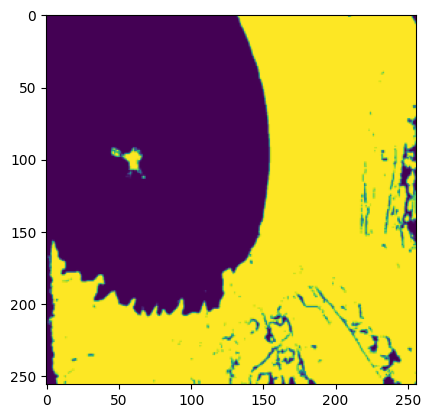

In [ ]:
# Plot output frame
plt.imshow(og_image)

tensor(0.9770, device='cuda:0', grad_fn=<MaxBackward1>)

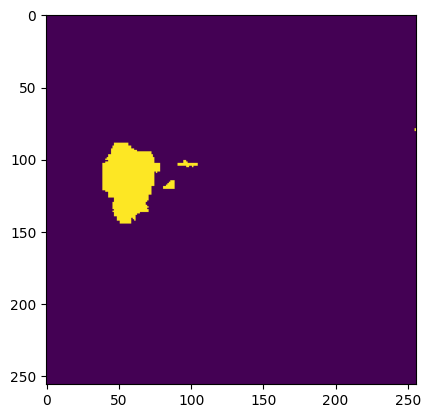

In [ ]:
prob_pred_frame = torch.sigmoid(pred_frame)
out = (prob_pred_frame > 0.5).to(torch.float32)
plt.imshow(out[0, 0, :, :].cpu().detach().numpy())
out.max()
prob_pred_frame.max()

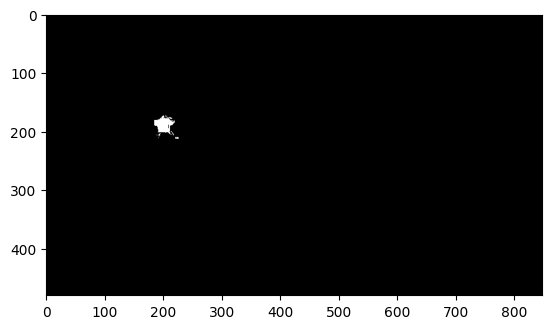

In [ ]:
# Actual gt
path_to_sequence = 'processed_flow/test3/targets'
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

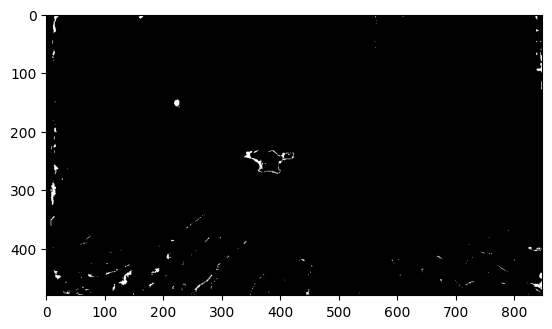

In [ ]:
# Actual gt
path_to_sequence = 'processed_flow/test1/inputs'
sequence_start = 1500
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

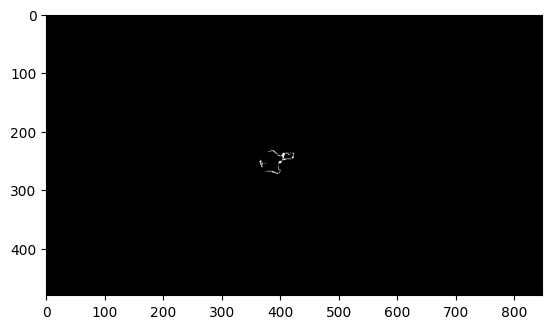

In [ ]:
# Actual gt
path_to_sequence = 'processed_flow/test1/targets'
idx = sequence_start + 4
img = io.imread(os.path.join(path_to_sequence, f'frame{idx:05d}.png'))
plt.imshow(img)

#### Testing dataloader

In [20]:
batch_size = 1
dataset = VideoDataset(path_to_data, augmented=augmented, num_vids=7, seq_length=seq_length, img_size=img_size)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0) #NOTE: num_workers is the number of extra processes running in parallel retrieving the data
counter = 0
for datapoint in loader:
    # found_one = False
    # features = datapoint['input']
    # labels = datapoint['target']
    if counter > 1:
        break
    counter += 1
    # for i in range(batch_size):
    #     image = features[0][i]
    #     if counter > 1502:
    #         found_one = True
    #         break
    #     counter += 1

    # if found_one:
    #     break

# counter
# len(datapoint)
in_frame = datapoint['input'][0][0, -1, 0, :, :]
out_frame = datapoint['target'][0, -1, 0, :, :]
# datapoint['input'][:, 0, :, :, :, 1]
# counter

100%|██████████| 7/7 [00:00<00:00, 169.65it/s]


In [ ]:
# Use transforms to resize images
# This is an example, but it must actually be performed before feeding image data to encoder
# For the augmented tensor the image is already resized inside the dataloader

sequence = next(iter(loader))
if augmented:
    input, target = sequence['input'], sequence['target']
    print(f'Tensor shape should be: [{batch_size, seq_length, 1, img_size, img_size, 14}] and is: {input.shape}')
else:

    features = sequence
    image = features['input'][0]
    input, target = features['input'], features['target']
    print(f'\nBatched image shape should be: [{batch_size, seq_length, 1, img_size, img_size}] and is: {image.shape}')


tensor(1.0000)


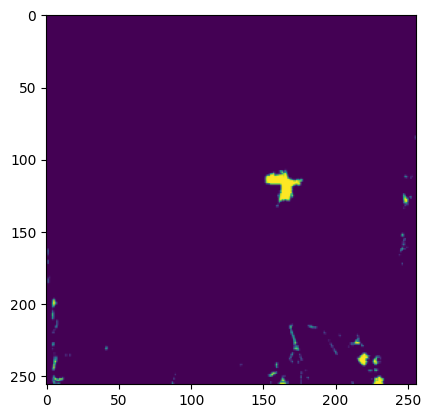

In [ ]:
print(in_frame.max())
plt.imshow(in_frame)

tensor(1.0000)


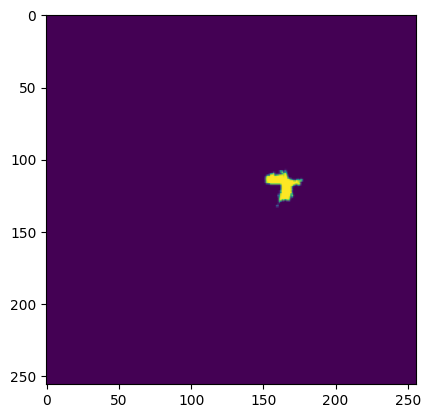

In [ ]:
print(out_frame.max())
plt.imshow(out_frame)

In [ ]:
features[0].shape
counter

1503

In [ ]:
pose = features[1]
pose[28]

tensor([-1.3603,  0.6753,  2.2040,  0.0300,  0.0131,  0.1257,  0.9915])

#### Testing interpolated twist

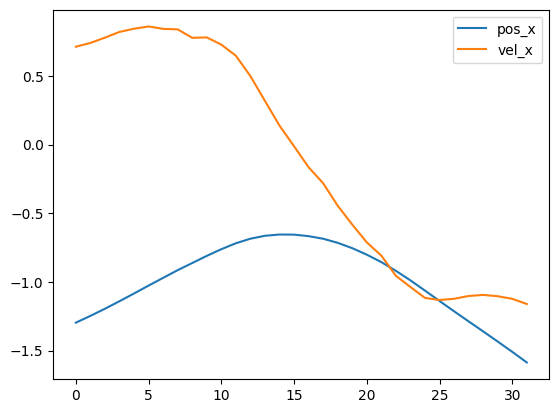

In [ ]:
features[1]
twist = features[2]

plt.plot(pose[:, 0])
plt.plot(twist[:, 0])
plt.legend(["pos_x", "vel_x"])
plt.show()

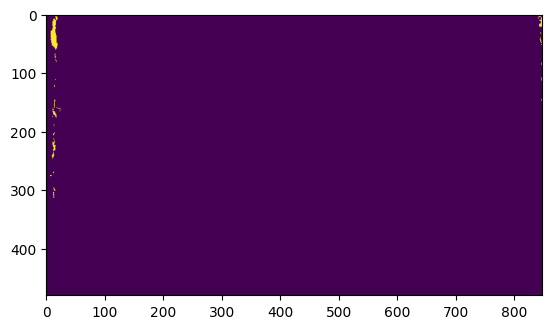

In [ ]:
image = features[0][28]
image.max()
plt.imshow(image)

torch.Size([32, 256, 256])